In [1]:
# folder path
import os
dir_path = "C://Users//vnarv//PycharmProjects//scoring_SDA/data/"
os.chdir("C://Users//vnarv//PycharmProjects//scoring_SDA/")

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
)
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from conf.config import data_inputs_paths as data_inputs

from src.preprocessing.preprocessing_x import PreprocessData
from src.preprocessing.transform_data import transform_data


##################### base line model ###########
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from conf.config import model_config
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# Package xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import time

from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, chi2, mutual_info_classif
# Package pour représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [9]:
path_x = data_inputs["path_prepro_x"]
path_y = data_inputs["path_prepro_y"]
df_x = pd.read_csv(path_x, sep=";")
df_y = pd.read_csv(path_y, sep=";")
# join x and y
df_x_y = pd.merge(df_x,
                  df_y,
                  left_on="FIPS_CODE",
                  right_on="COUNTY_FIPS",
                  how="inner")
index_cols = ["STATE_NAME",
              "AREA_NAME"]
df_x_y = df_x_y.set_index(["STATE_NAME", "COUNTY_FIPS"], drop=True)
# FIXME : county code is repeated after join
df_x_y = df_x_y.drop("FIPS_CODE", axis=1)

X_prepro = df_x_y.drop(["TARGET", "AREA_NAME"], axis=1)
y_prepro = df_x_y[["TARGET"]]
# split train, test
X_train, X_test, y_train, y_test = train_test_split(
    X_prepro,
    y_prepro,
    test_size=0.2,
    random_state=42,
    stratify=y_prepro["TARGET"]  # FIXME: stratify par state?
)
print("\n\n Repartition de la target:")
print(y_train.TARGET.value_counts(normalize=True))

for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)



 Repartition de la target:
0    0.82724
1    0.17276
Name: TARGET, dtype: float64
(2489, 154)
(623, 154)
(2489, 1)
(623, 1)


In [47]:
# define random state
seed = 123

# define class weights
class_weight = model_config["class_weight"]
cw = compute_class_weight(
    class_weight,
    classes=np.unique(y_train["TARGET"]),
    y=y_train["TARGET"],
)
cw_dict = dict(enumerate(cw))
cw_dict

{0: 0.6044196211753279, 1: 2.894186046511628}

# Exploring different base algorithms with RFE

In [48]:
# option 1 : definir le nb de features et applique decision trees
# get a list of models to evaluate
def get_models(weights=cw_dict, n_features=50):
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['lr'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['cart'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(class_weight=weights), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['rf'] = Pipeline(steps=[('s', rfe), ('m', model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=n_features)
    model = RandomForestClassifier()
    models['gbm'] = Pipeline(steps=[('s', rfe), ('m', model)])
    return models


# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
start = time.time()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train["TARGET"])
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
end = time.time()
delta = (end - start) / 60
print(f"modelisation took {delta:.2} minutes")

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.savefig("images/model_performance_RFE")

KeyboardInterrupt: 

# Exploring RFE with CV integrated for feature selection. Then model with different algorithms 

In [15]:
def compute_RFECV(X, y, estimator=RandomForestClassifier(class_weight=cw_dict)):
    # Instanciation de la RFECV()
    rfecv_selector = RFECV(estimator=estimator,
                           min_features_to_select=10,
                           scoring='f1_macro',
                           n_jobs=-1,
                           step=1,
                           cv=5
                           )

    # Entraîner le modèle
    rfecv_selector.fit(X, y)
    mean_test_f1_score = rfecv_selector.cv_results_["mean_test_score"]
    n_features_selected = rfecv_selector.n_features_
    min_features_to_select = rfecv_selector.min_features_to_select
    n_features_in_rfecv = rfecv_selector.n_features_in_

    fig = px.line(y=mean_test_f1_score,
                  x=range(min_features_to_select, len(mean_test_f1_score) + min_features_to_select),
                  labels={
                      "x": "Nombre de variables sélectionnées",
                      "y": "Score moyen de cross-validaion"
                  },
                  title=f"Résultats RFECV avec {rfecv_selector.cv} k-fold"
                  )
    fig.add_vline(x=n_features_selected, line_width=3, line_dash="dash", line_color="#011C5D")
    fig.add_vrect(x0=30, x1=n_features_in_rfecv, line_width=0, fillcolor="#D38F00", opacity=0.2)
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/RFE_random_forest.png")

    # Récupérer la liste des variables issues de RFECV et transformer là en liste
    rfe_features = rfecv_selector.get_feature_names_out().tolist()
    return rfe_features

models = {
    "LogisticRegression":
        LogisticRegression(
            max_iter=1000,
            random_state=seed,
            class_weight=cw_dict
        ),
    "BaggingClassifier":
        BaggingClassifier(
            n_estimators=300,
            random_state=seed
        ),
    "RandomForestClassifier":
        RandomForestClassifier(
            n_estimators=300,
            class_weight=cw_dict,
            max_depth=3,
            random_state=seed,
        ),
    "GradientBoosting":
        GradientBoostingClassifier(
            n_estimators=300,
            max_depth=3,
            random_state=seed
        ),
    "XGBClassifier":
        XGBClassifier(
            use_label_encoder=False,
            n_estimators=80,
            eval_metric='logloss',
            random_state=seed,
            learning_rate=0.1
        )
}


def fit_model(X, y, estimator, **kwargs):
    model = Pipeline(
        steps=[
            ("estimator", estimator)
        ]
    )

    return model.fit(X, y, **kwargs)

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores


# fit random forest with RFE to select variables
rfe_RF_features = compute_RFECV(X_train, y_train["TARGET"])
print('>The selected features by RFE are : \n %s' % (rfe_RF_features))

results_train, results_test, names = list(), list(), list()
# Boucler sur chacun des modèles
for name, model in models.items():
    fit_m = fit_model(X_train[rfe_RF_features], y_train["TARGET"], model)
    scores_train = evaluate_model(fit_m, X_train[rfe_RF_features], y_train["TARGET"])
    y_pred_test = fit_m.predict(X_test[rfe_RF_features])
    F1_test = f1_score(y_test["TARGET"], y_pred_test)
    results_train.append(scores_train)
    results_test.append(F1_test)
    names.append(name)
    print('>%s %.3f (train) %.3f (test)' % (name, mean(scores_train), F1_test))



>The selected features by RFE are : 
 ['GQ_ESTIMATES_2011', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__1990', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__2000', 'PERCENT_OF_ADULTS_WITH_A_BACHELOR_S_DEGREE_OR_HIGHER__2000', 'PERCENT_OF_ADULTS_WITH_A_HIGH_SCHOOL_DIPLOMA_ONLY__2015_19', 'PCTPOVALL_2019', 'MED_HH_INCOME_PERCENT_OF_STATE_TOTAL_2019', 'UNEMPLOYMENT_RATE_2012', 'INTERNATIONAL_MIG_2014', 'DOMESTIC_MIG_2010', 'DOMESTIC_MIG_2011', 'CIVILIAN_LABOR_FORCE_2001', 'MEDHHINC_2019']
>LogisticRegression 0.771 (train) 0.705 (test)
>BaggingClassifier 0.810 (train) 0.677 (test)
>RandomForestClassifier 0.771 (train) 0.680 (test)
>GradientBoosting 0.806 (train) 0.720 (test)


C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



>XGBClassifier 0.805 (train) 0.704 (test)


In [5]:
0.775-0.694


0.08100000000000007

In [6]:
0.809-0.713

0.09600000000000009

In [7]:
 0.776-0.664

0.11199999999999999

In [8]:
0.806-0.708

0.09800000000000009

#  Grid search 

In [49]:
params_grid = {
    "LogisticRegression":
        {'solver': ['liblinear', 'lbfgs'],
         },
    "BaggingClassifier":
        {'n_estimators': [100, 200, 300],
         'max_features': [1, 3],
         'max_samples': [1, 5, 10]
       } ,
    "RandomForestClassifier":
        {'n_estimators': [100, 200, 300],
         'min_samples_split':[2, 5, 10],
         'max_depth': [None, 3, 10, 20],
         
        },
    "XGBClassifier":
       {'gamma': [0, 0.1, 0.3],
              'learning_rate': [0.01, 0.1, 0.3],
              'max_depth': [3, 5, 6],
              'n_estimators': [50, 80, 100, 120],
              #'reg_alpha': [0, 0.1, 0.4, 1],
              #'reg_lambda': [0, 0.1, 0.4, 1]
             }
}


estimators = {
    "LogisticRegression":
        LogisticRegression(
            max_iter=1000,
            random_state=seed,
            class_weight=cw_dict
        ),
    "BaggingClassifier":
        BaggingClassifier(
            random_state=seed
        ),
    "RandomForestClassifier":
        RandomForestClassifier(
            class_weight=cw_dict,
            random_state=seed,
        ),
    "XGBClassifier":
        XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=seed,
        )
}


C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



In [15]:
for name, model in params_grid.items():
    print(name, model.keys())
    

LogisticRegression dict_keys(['solver'])
BaggingClassifier dict_keys(['n_estimators', 'max_features'])
RandomForestClassifier dict_keys(['n_estimators', 'min_samples_split'])
XGBClassifier dict_keys(['gamma', 'learning_rate', 'max_depth', 'n_estimators', 'reg_alpha', 'reg_lambda'])


In [52]:
print(len(X_train)/5)

497.8


In [ ]:
for key in set(params_grid.keys()) & set(estimators.keys()):
    print(key)
    print(params_grid[key])
    print(estimators[key])
    print('>%s:' % (key))
    gridSearch_best_model(params_grid[key],
                          estimators[key],
                          X_train[rfe_RF_features],
                          y_train["TARGET"],
                          X_test[rfe_RF_features],
                          y_test["TARGET"]
                         )



LogisticRegression
{'solver': ['liblinear', 'lbfgs']}
LogisticRegression(class_weight={0: 0.6044196211753279, 1: 2.894186046511628},
                   max_iter=1000, random_state=123)
>LogisticRegression:
Fitting 10 folds for each of 2 candidates, totalling 20 fits

 >>f1 score: 0.643 (train) 0.705 (test)


 >>auc: 0.744 (train) 0.807 (test)


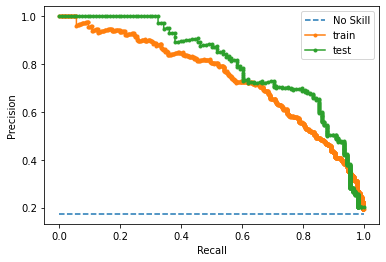

LogisticRegression(class_weight={0: 0.6044196211753279, 1: 2.894186046511628},
                   max_iter=1000, random_state=123, solver='liblinear')
RandomForestClassifier
{'n_estimators': [100, 200, 300], 'min_samples_split': [2, 5, 10], 'max_depth': [None, 3, 10, 20]}
RandomForestClassifier(class_weight={0: 0.6044196211753279,
                                     1: 2.894186046511628},
                       random_state=123)
>RandomForestClassifier:
Fitting 10 folds for each of 36 candidates, totalling 360 fits

 >>f1 score: 0.967 (train) 0.732 (test)


 >>auc: 0.995 (train) 0.771 (test)


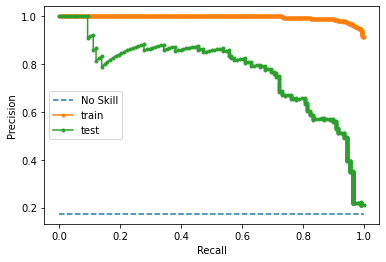

RandomForestClassifier(class_weight={0: 0.6044196211753279,
                                     1: 2.894186046511628},
                       min_samples_split=10, random_state=123)
XGBClassifier
{'gamma': [0, 0.1, 0.3], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 6], 'n_estimators': [50, 80, 100, 120]}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
    

C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

C:\Users\vnarv\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.




 >>f1 score: 1.000 (train) 0.704 (test)


 >>auc: 1.000 (train) 0.809 (test)


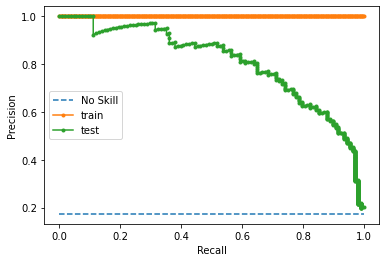

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=123, ...)
BaggingClassifier
{'n_estimators': [100, 200, 300], 'max_features': [1, 3], 'max_samples': [1, 5, 10]}
BaggingClassifier(random_state=123)
>BaggingClassifier:
Fitting 10 folds for each of 18 candidates, totalling 180 fits

 >>f1 score: 0.388 (train) 0.479 (test)


 >>auc: 0.693 (train) 

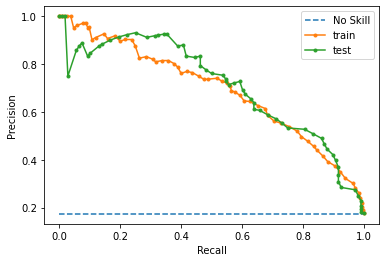

BaggingClassifier(max_features=3, max_samples=10, n_estimators=100,
                  random_state=123)


In [54]:
for key in set(params_grid.keys()) & set(estimators.keys()):
    print(key)
    print(params_grid[key])
    print(estimators[key])
    print('>%s:' % (key))
    gridSearch_best_model(params_grid[key],
                          estimators[key],
                          X_train[rfe_RF_features],
                          y_train["TARGET"],
                          X_test[rfe_RF_features],
                          y_test["TARGET"]
                         )



In [53]:
def gridSearch_best_model(grid, estimator_gs, X_train_class, y_train_class, X_test_class, y_test_class):
 
    cv_grid_search = GridSearchCV(
    estimator=estimator_gs,
    param_grid=grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=10,
    verbose=2
    )
    
    # Entrainement et évaluation du modèle
    gs_fit = fit_model(X_train_class, y_train_class, cv_grid_search)
    
    calculate_precision_recall_curve(gs_fit, X_train_class, y_train_class, X_test_class, y_test_class)
    
    print(cv_grid_search.best_estimator_)

    return cv_grid_search.best_estimator_
    

In [43]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
def calculate_precision_recall_curve(model, trainX, trainy, testX, testy):
     
    # metrics
    md_precision_train, md_recall_train, md_f1_train, md_auc_train = _metrics(model, trainX, trainy)
    md_precision_test, md_recall_test, md_f1_test, md_auc_test = _metrics(model, testX, testy)
   
    print('\n >>f1 score: %.3f (train) %.3f (test)\n' % (md_f1_train, md_f1_test))    
    print('\n >>auc: %.3f (train) %.3f (test)' % (md_auc_train, md_auc_test))
    
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(md_recall_train, md_precision_train, marker='.', label='train')
    pyplot.plot(md_recall_test, md_precision_test, marker='.', label='test')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [44]:
def _metrics(model, X, y):
    # predict proba
    md_proba = model.predict_proba(X)
    #keep only positive outcome
    md_proba = md_proba[:, 1]
    #predict class value
    y_hat = model.predict(X)
    
    #calculate precision and recall for each threshold
    md_precision, md_recall, _ = precision_recall_curve(y, md_proba)
    # calculate f1 and auc
    md_f1, md_auc = f1_score(y, y_hat), auc(md_recall, md_precision)
    
    metrics = md_precision, md_recall, md_f1, md_auc
    
    return metrics